In [1]:
from obspy import UTCDateTime
import pandas as pd
import re


# print("\033[91mTexte en rouge\033[0m")
# print("\033[92mTexte en vert\033[0m")
# print("\033[93mTexte en jaune\033[0m")
# print("\033[94mTexte en bleu\033[0m")
# print("\033[95mTexte en magenta\033[0m")
# print("\033[96mTexte en cyan\033[0m")


In [2]:
catalog_path = "Turkey_data/catalog"
seismic_data = "Turkey_data/DATA"

# https://github.com/AI4EPS/PhaseNet

In [5]:
def parse_catalog_txt_detailed(filepath, max_distance=80000, debug=False):
    """
    Parse a seismic catalog text file and extract earthquake events with station data.

    Args:
        filepath (str): Path to the catalog text file
        max_distance (float): Maximum station distance in km (default: 80km)
        debug (bool): Enable debug output for invalid events

    Returns:
        tuple: (events_dict, total_events, valid_events, deleted_no_mag, deleted_empty_stations)
    """

    # Read all lines from the catalog file
    events = {}
    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Current event tracking variables
    current_event_id = None
    current_event_mag = None
    current_event_time = None
    stations_list = []
    reading_stations = False

    # Statistics variables for parsing summary
    total_events = 0
    deleted_by_no_mag = 0
    deleted_by_empty_stations = 0
    valid_event = 0

    # Main parsing loop - process each line of the catalog file
    for i, line in enumerate(lines):
        if line.startswith("EVENT"):

            # Save the previous event if it exists and is valid
            if current_event_id is not None :
                total_events += 1

                # Check if event has magnitude data - reject if missing
                if current_event_mag is None :
                    deleted_by_no_mag += 1
                    if debug :
                        print(f"\033[93mThe event {current_event_id} has no mag data\033[0m")

                # Check if event has station data - reject if the station list is empty
                if len(stations_list) == 0:
                    deleted_by_empty_stations += 1
                    if debug :
                        print(f"\033[93mThe event {current_event_id} has no valid stations\033[0m")

                # Save valid event with both magnitude and station data
                else :
                    valid_event += 1
                    events[current_event_id] = {
                        "magnitude": current_event_mag,
                        "stations": stations_list,
                        "eq_start_time": current_event_time
                    }

                # Reset variables for next event
                stations_list = []
                current_event_mag = None
                current_event_time = None

            # Extract new event ID from EVENT line (format: "EVENT event_id")
            current_event_id = line.strip().split()[1]
            reading_stations = False

        # Process event information line with full date (e.g., "2023/06/01 00:22:32.8 ... ML 1.5 ...")
        elif current_event_id and re.search(r'\d{4}/\d{2}/\d{2}', line) and not reading_stations:
            parts = line.strip().split()

            # Look for magnitude information (ML = Local Magnitude, MD = Duration Magnitude)
            if "ML" in parts or "MD" in parts:
                try:
                    mag_index = None
                    if "ML" in parts:
                        mag_index = parts.index("ML")
                    if "MD" in parts:
                        mag_index = parts.index("MD")

                    # Extract magnitude value and event time
                    current_event_mag = float(parts[mag_index + 1])
                    current_event_time = parts[1]  # garde "00:22:32.8"
                except (ValueError, IndexError):
                    # Handle parsing errors
                    current_event_mag = None
                    current_event_time = None
            reading_stations = False

        # Detect station data header line (starts with "Sta" and contains "Phase")
        elif line.strip().startswith("Sta") and "Phase" in line:
            reading_stations = True
            continue

        # Process individual station data lines
        elif reading_stations and line.strip():
            cols = line.split()

            # Filter 1: Keep only stations with P-wave arrivals ("Pg" phase)
            if "Pg" not in line: continue

            # Filter 2: Keep only stations with magnitude measurements
            if "ML" not in cols: continue

            # Convert distance from degrees to kilometers (1 degree ≈ 111 km)
            true_distance = float(cols[1]) * 111

            # Filter 3: Skip stations with invalid distance (0 km)
            if true_distance == 0 : continue

            # Filter 4: Skip stations beyond maximum distance threshold
            if true_distance > max_distance: continue

            station_name = cols[0]

            try:
                # Extract station-specific magnitude measurement
                ml_idx = cols.index("ML")
                mag_station = float(cols[ml_idx + 1])

                # Extract station arrival time information
                date_str = cols[5]  # "2021/04/10"
                time_str = cols[6]  # "00:11:10.9"
                datetime_str = f"{date_str} {time_str}"
                starttime = UTCDateTime(datetime_str)

            except (ValueError, IndexError):
                # Skip station if parsing fails
                continue

            # Add valid station data to current event
            stations_list.append({
                "station": station_name,
                "distance": true_distance,
                "mag": mag_station,
                "start_time": starttime
            })

    # Process the final event in the file (no EVENT line follows)
    if current_event_id is not None:
        # Check if final event has magnitude data
        if current_event_mag is None :
            deleted_by_no_mag += 1
            if debug :
                print(f"\033[93mThe event {current_event_id} has no mag data\033[0m")

        # Check if final event has station data
        if len(stations_list) == 0: # To invalid events with empty stations
            deleted_by_empty_stations += 1
            if debug :
                print(f"\033[93mThe event {current_event_id} has no valid stations\033[0m")

        # Save final valid event
        else :
            events[current_event_id] = {
                "magnitude": current_event_mag,
                "stations": stations_list,
                "eq_start_time": current_event_time
            }

    # Return parsed events and statistics
    return events, total_events, valid_event, deleted_by_no_mag, deleted_by_empty_stations

Case for checking the results of the parsing

In [11]:
one_file, total_events, valid_event, deleted_by_no_mag, deleted_by_empty_stations = parse_catalog_txt_detailed("Turkey_data/Catalog/2021_04.txt")

print(f"Statistics: There have been {valid_event} valid events, {deleted_by_no_mag} events deleted because of lack of magnitude, {deleted_by_empty_stations} events deleted because of empty stations.")
print(f"There were {total_events} total events")


Statistics: There have been 2971 valid events, 0 events deleted because of lack of magnitude, 29 events deleted because of empty stations.
There were 3000 total events


In [13]:
def parse_all_catalogs(catalog_folder, max_distance=80000, debug=False):
    """
    Parse all catalog text files in a folder and merge them into a single dictionary.

    Args:
        catalog_folder (str): Path to folder containing catalog .txt files
        max_distance (float): Maximum station distance in km (default: 80km)
        debug (bool): Enable debug output for invalid events

    Returns:
        dict: Merged dictionary of all catalog events with structure:
              { event_id: { "magnitude": float,
                           "stations": [ {station, distance, mag, start_time}, ... ],
                           "eq_start_time": str } }
    """

    # Initialize merged events dictionary and global statistics counters
    all_events = {}
    total_deleted_by_no_mags = 0
    total_deleted_by_empty_stations = 0
    total_valid_events = 0
    sum_total_events = 0

    # Process each .txt file in the catalog folder
    for filename in os.listdir(catalog_folder):
        if filename.endswith(".txt"):

            # Build full file path
            path = os.path.join(catalog_folder, filename)
            print(f"📄 Parsing {filename}...")
            # Parse individual catalog file and get statistics
            events, total_events, valid_event, deleted_by_no_mag, deleted_by_empty_stations = parse_catalog_txt_detailed(path, max_distance=max_distance, debug=debug)

            # Accumulate statistics across all files
            sum_total_events += total_events
            total_valid_events += valid_event
            total_deleted_by_no_mags += deleted_by_no_mag
            total_deleted_by_empty_stations += deleted_by_empty_stations

            # Merge events into global dictionary, checking for duplicates
            for event_id, data in events.items():
                if event_id in all_events:
                    # Handle duplicate event IDs across different files
                    print(f"⚠️ Warning: duplicate event ID {event_id} found in {filename}, skipping...")
                    continue
                all_events[event_id] = data

    # Print final statistics for all processed files
    print(f"Statistics : There has been {total_valid_events} valid events, {total_deleted_by_no_mags} events deleted because of lack of magnitude, {total_deleted_by_empty_stations} stations deleted because empty stations.")
    print(f"There was {sum_total_events} total events")
    return all_events

In [14]:
all_files = parse_all_catalogs(catalog_path, max_distance=80000, debug=False)


📄 Parsing 20080101-20081231_GSE2.txt...
📄 Parsing 20090101-20091231_GSE2.txt...
📄 Parsing 20100101-20101231_GSE2.txt...
📄 Parsing 20110101-20111231_GSE2.txt...
📄 Parsing 20120101-20121231_GSE2.txt...
📄 Parsing 20130101-20131231_GSE2.txt...
📄 Parsing 20140101-20141231_GSE2.txt...
📄 Parsing 20150101-20151231_GSE2.txt...
📄 Parsing 20160101-20161231_GSE2.txt...
📄 Parsing 20170101-20171231_GSE2.txt...
📄 Parsing 20180101-20181231_GSE2.txt...
📄 Parsing 20190101-20190131_GSE2.txt...
📄 Parsing 20190201-20190228_GSE2.txt...
📄 Parsing 20190301-20190331_GSE2.txt...
📄 Parsing 20190401-20190431_GSE2.txt...
📄 Parsing 20190501-20190531_GSE2.txt...
📄 Parsing 20190601-20190631_GSE2.txt...
📄 Parsing 20190701-20190731_GSE2.txt...
📄 Parsing 20190801-20190831_GSE2.txt...
📄 Parsing 20190901-20190931_GSE2.txt...
📄 Parsing 20191001-20191031_GSE2.txt...
📄 Parsing 20191101-20191131_GSE2.txt...
📄 Parsing 20191201-20191231_GSE2.txt...
📄 Parsing 20200101-20200131_GSE2.txt...
📄 Parsing 20200201-20200231_GSE2.txt...


In [14]:
print(len(all_files))

288043


Extracting trace and joining info to create dataset


Checking functions

In [15]:
def check_snippet_shapes(samples):
    """
    Verify that all snippets in the dataset have exactly the same shape.

    This function is crucial for machine learning pipelines to ensure data consistency
    before training or processing seismic waveform snippets.

    Args:
        samples (list): List of sample dictionaries, each containing a "snippet" key
                       with numpy array data (e.g., seismic waveform data)

    Returns:
        bool: True if all snippets have identical shapes, False otherwise
    """

    # Extract all unique shapes from the snippets using a set
    # This automatically eliminates duplicates and gives us unique dimensions
    shapes = set(sample["snippet"].shape for sample in samples)

    # Check if all snippets have the same shape (only one unique shape exists)
    if len(shapes) == 1:
        # All snippets are consistent - get the common shape
        print(f"✅ Every snippets have the same size : {shapes.pop()}")
        return True
    else:
        # Multiple shapes found - this indicates inconsistent data
        print(f"❌ Found snippets that doesnt have the same size : {shapes} :")
        for s in shapes:
            print(f" - {s}")
        return False


In [17]:
def check_nan_inf(samples):
    """
    Check for NaN (Not a Number) and Inf (Infinity) values in seismic snippet data.

    This function validates data quality by detecting invalid numerical values that
    could cause issues in machine learning models or signal processing algorithms.
    NaN/Inf values often indicate data corruption, instrument malfunctions, or
    processing errors in seismic data acquisition.

    Args:
        samples (list): List of sample dictionaries, each containing:
                       - "snippet": numpy array with seismic waveform data
                       - "event_id": identifier for the earthquake event
                       - "station": name of the recording station

    Returns:
        bool: True if no NaN/Inf values found, False if invalid values detected
    """

    # Iterate through all samples to check data integrity
    for i, sample in enumerate(samples):

        # Check for NaN (Not a Number) values in the snippet
        has_nan = np.isnan(sample["snippet"]).any()

        # Check for Inf (Infinity) values in the snippet
        has_inf = np.isinf(sample["snippet"]).any()

        # If either NaN or Inf values are found, report the problematic sample
        if has_nan or has_inf:
            print(f"❌ NaN/Inf values detected in sample #{i} – Event {sample['event_id']} / Station {sample['station']}")
            return False
    print(f"✅ No NaN/Inf values found in {len(samples)} samples")
    return True


In [18]:
def plot_metadata_distribution(samples):
    """
    Plot the distribution of earthquake magnitudes and station distances.

    This function creates side-by-side histograms to visualize the statistical
    distribution of key seismic parameters in the dataset. This helps assess
    data balance and identify potential biases in magnitude ranges or distance
    coverage that could affect machine learning model performance.

    Args:
        samples (list): List of sample dictionaries, each containing:
                       - "event_magnitude": earthquake magnitude value (float)
                       - "distance_m": station distance in meters (float)

    Returns:
        None: Displays the plots directly
    """
    mags = [s["event_magnitude"] for s in samples]
    dists = [s["distance_m"] for s in samples]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(mags, bins=20, color="skyblue", edgecolor="black")
    plt.title("Magnitude distributions")

    plt.subplot(1, 2, 2)
    plt.hist(dists, bins=20, color="lightcoral", edgecolor="black")
    plt.title("Distance distributions (m)")

    plt.tight_layout()
    plt.show()


In [25]:
import random
from obspy import read

def plot_random_snippet_with_original(samples, data_folder):
    """
    Display a random seismic sample showing both the complete original trace
    and the extracted snippet with Z/N/E components overlaid.

    This function is useful for visual quality control of the data preprocessing
    pipeline, allowing verification that snippets are correctly extracted from
    the original seismic recordings and that all three components (vertical,
    north-south, east-west) are properly aligned.

    Args:
        samples (list): List of sample dictionaries, each containing:
                       - "snippet": 3D numpy array [3, n_samples] with Z/N/E data
                       - "event_id": earthquake event identifier
                       - "station": recording station name
        data_folder (str): Path to folder containing original .mseed files

    Returns:
        None: Displays the comparison plots directly
    """

    # Randomly select a sample for visualization
    sample = random.choice(samples)
    snippet = sample["snippet"]
    event_id = sample["event_id"]
    station_name = sample["station"]

    print(f"Displaying sample: Event {event_id} at Station {station_name}")

    # Load the original seismic recording file
    original_path = os.path.join(data_folder, f"{event_id}.mseed")
    try:
        stream = read(original_path)
    except Exception as e:
        print(f"❌ Error reading file {original_path}: {e}")
        return

    # Extract traces from the specific station
    station_traces = [tr for tr in stream if tr.stats.station == station_name]

    # Organize traces by component (Z=vertical, N=north-south, E=east-west)
    components = {tr.stats.channel[-1]: tr for tr in station_traces if tr.stats.channel[-1] in ("Z", "N", "E")}

    # Validate that all three components are available
    if len(components) < 3:
        print(f"❌ Station {station_name} missing components.")
        return

    # Create comparison figure with two subplots
    plt.figure(figsize=(14, 6))

    # ➤ Graphe 1 : trace originale
    plt.subplot(2, 1, 1)
    for comp, color in zip(["Z", "N", "E"], ["blue", "green", "red"]):
        plt.plot(components[comp].data.astype(np.float32), label=comp, color=color)
    plt.title(f"Complete original trace – Event {event_id} / Station {station_name} - Magnitude : {sample['event_magnitude']}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()

    # ➤ Graphe 2 : snippet
    plt.subplot(2, 1, 2)
    for i, (label, color) in enumerate(zip(["Z", "N", "E"], ["blue", "green", "red"])):
        plt.plot(snippet[i], label=label, color=color)
    plt.title("Snippet extracted")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()

Extraction functions

In [19]:

# # USE THIS FUNCTION JUST ONE TIME TO GET THE LOWEST SAMPLING RATE
# # Try to work in sample rate of 100
#
# import os
# from collections import defaultdict, Counter
# import matplotlib.pyplot as plt
# from obspy import read
#
# def get_sampling_info(data_folder):
#     station_rates = defaultdict(set)
#     rate_distribution = Counter()
#
#     for root, _, files in os.walk(data_folder):
#         for f in files:
#             if f.endswith(".mseed"):
#                 try:
#                     for tr in read(os.path.join(root, f)):
#                         sr, sta = tr.stats.sampling_rate, tr.stats.station
#                         station_rates[sta].add(sr)
#                         rate_distribution[sr] += 1
#                 except Exception as e:
#                     print(f"⚠️ {f} : {e}")
#
#     all_rates = set(rate_distribution.keys())
#     return station_rates, all_rates, rate_distribution
#
# # Usage
# station_rates, all_rates, rate_distribution = get_sampling_info(seismic_data)
#
# print("Tous les sampling rates :", sorted(all_rates))
# print("\nDistribution :")
# for r, c in sorted(rate_distribution.items()):
#     print(f"{r} Hz: {c} traces")


In [20]:
import matplotlib.pyplot as plt

def plot_snippet_vs_original_superposed(traces, snippet_array, offset_seconds, seconds=3, station_name=None):
    """
    Affiche toutes les composantes Z/N/E superposées :
    - en noir : trace originale
    - en bleu : snippet aligné sur onde P
    - en rouge pointillé : onde P

    Params:
        - traces : list of obspy.Trace
        - snippet_array : np.array (3, n_samples)
        - offset_seconds : float (début du snippet par rapport à starttime)
    """
    components = {"Z": None, "N": None, "E": None}
    for tr in traces:
        comp = tr.stats.channel[-1]
        if comp in components:
            components[comp] = tr

    fig, ax = plt.subplots(figsize=(12, 5))

    colors = {"Z": "black", "N": "green", "E": "purple"}
    snippet_colors = {"Z": "blue", "N": "blue", "E": "blue"}
    times_snippet = np.linspace(0, seconds, snippet_array.shape[1])

    for i, comp in enumerate(["Z", "N", "E"]):
        tr = components[comp]
        if tr is None:
            continue

        times_full = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts)
        ax.plot(times_full, tr.data, label=f"Originale {comp}", color=colors[comp], alpha=0.4)

        # Snippet placé à la bonne position
        ax.plot(times_snippet + offset_seconds, snippet_array[i], label=f"Snippet {comp}", color=snippet_colors[comp], linewidth=2)

    # Onde P marquée
    ax.axvline(offset_seconds, color="red", linestyle="--", label="Arrivée Onde P")

    ax.set_title(f"Station {station_name or 'inconnue'} – Composantes superposées")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


In [21]:

import os
import numpy as np

def build_station_snippet_dataset(data_folder, events_dict, seconds=3, sample_rate=100.0):
    """
    Extract seismic waveform snippets around P-wave arrivals for machine learning.

    This function processes .mseed files and extracts standardized 3-component (Z/N/E)
    seismic snippets centered on P-wave arrival times. Each snippet contains a fixed
    time window with pre-event buffer for signal analysis.

    Args:
        data_folder (str): Path to folder containing .mseed seismic files
        events_dict (dict): Dictionary mapping event_id to event metadata containing
                           magnitude and station list with arrival times
        seconds (float): Duration of snippet after P-wave arrival (default: 3s)
        sample_rate (float): Target sampling rate in Hz (default: 100 Hz)

    Returns:
        list: List of sample dictionaries, each containing:
              - "event_id": earthquake event identifier
              - "station": recording station name
              - "distance_m": station distance in meters
              - "station_ml": station-specific magnitude
              - "event_magnitude": event magnitude
              - "sampling_rate": sampling rate used
              - "snippet": 3D array [3, n_samples] with Z/N/E components
    """
    samples = []

    # Initialize comprehensive statistics counters for data quality assessment
    total_traces = 0
    file_invalidated_because_of_not_in_catalog = 0
    file_invalidated_because_of_bad_reading = 0
    traces_invalidated_because_of_not_in_stations_list = 0
    traces_invalidated_because_of_bad_sampling_rate = 0
    traces_invalidated_because_of_no_matching = 0
    traces_invalidated_because_of_missing_components = 0
    traces_invalidated_because_of_trim_error = 0
    traces_invalidated_because_of_invalid_snippet_amount = 0
    valid_traces = 0

    # Main processing loop: iterate through all seismic data files
    for fname in os.listdir(data_folder):

        # Filter: only process .mseed seismic data files
        if not fname.endswith(".mseed"):
            continue

        # Extract event ID from filename (assumes format: "event_id.mseed")
        event_id = fname.replace(".mseed", "")

        # Validation 1: Check if event exists in the catalog
        if event_id not in events_dict:
            file_invalidated_because_of_not_in_catalog +=1
            continue

        # Retrieve event metadata (magnitude, station list with arrival times)
        event_meta = events_dict[event_id]

        # Validation 2: Attempt to read the seismic data file
        try:
            stream = read(os.path.join(data_folder, fname))
        except Exception as exc:
            print(f"❌ Lecture échouée : {fname} – {exc}")
            file_invalidated_because_of_bad_reading += 1
            continue

        # Create lookup set of stations that have catalog entries for this event
        stations_in_event = set(s["station"] for s in event_meta["stations"])

        # Group traces by recording station for multi-component processing
        traces_by_station = {}
        stream = stream.merge() # Merge any gaps in the continuous data

        for tr in stream:

            total_traces += 1
            station = tr.stats.station.strip()

            # Validation 3: Check if station has catalog metadata
            if station not in stations_in_event:
                traces_invalidated_because_of_not_in_stations_list += 1
                continue

            # Validation 4: Ensure adequate sampling rate for processing
            if tr.stats.sampling_rate < sample_rate:
                traces_invalidated_because_of_bad_sampling_rate +=1
                continue

            # Group traces by station for component assembly, basically it's a dict of station with his traces
            traces_by_station.setdefault(station, []).append(tr)

        # Process each station individually to extract 3-component snippets
        for station, traces in traces_by_station.items():
            # Organize traces by seismic component Z/N/E
            components = {tr.stats.channel[-1]: tr for tr in traces if tr.stats.channel[-1] in ("Z", "N", "E")}

            # Validation 5: Ensure all three components are available
            if len(components) < 3:
                traces_invalidated_because_of_missing_components += len(components)
                continue

            # Validation 6: Retrieve station metadata (P-wave arrival time, distance, etc.)
            st_meta = next((s for s in event_meta["stations"] if s["station"] == station), None)
            if not st_meta:
                traces_invalidated_because_of_no_matching += len(components)
                continue

            # Prepare snippet extraction with standardized dimensions
            station_time_sec = st_meta["start_time"]
            n_samples = int(sample_rate * seconds)
            snippet = []

            # Process each component (Z, N, E) to create aligned time series
            for comp_key in ("Z", "N", "E"):
                tr = components[comp_key].copy()

                try:
                    # Resample and detrend if necessary for standardization
                    if tr.stats.sampling_rate != sample_rate:
                        tr = tr.resample(sample_rate)
                        tr = tr.detrend(type="linear")

                    # Extract time window: 2 seconds before P-arrival + specified duration after
                    # This provides pre-event baseline and captures P-wave + early S-wave
                    tr = tr.trim(station_time_sec - 2, station_time_sec + seconds - 0, pad=True, fill_value=0)
                except Exception as e:
                    print(f"⚠️ Erreur trim/resample station {station}: {e}")
                    traces_invalidated_because_of_trim_error += len(components)
                    break

                data = tr.data.astype(np.float32)
                # Ensure exact length through padding or truncation
                if len(data) < n_samples:
                    data = np.pad(data, (0, n_samples - len(data)), mode='constant')
                elif len(data) > n_samples:
                    data = data[:n_samples]

                snippet.append(data)

            # Validation 7: Ensure all three components were processed successfully
            if len(snippet) != 3:
                traces_invalidated_because_of_invalid_snippet_amount += len(components)
                continue

            # Create final 3D array: [components, time_samples]
            snippet_array = np.stack(snippet)  # Shape: [3, n_samples]

            # plot_snippet_vs_original_superposed(traces, snippet_array, offset, seconds=seconds, station_name=station)
            # plot_snippet_vs_original_superposed(traces, snippet_array,
            #     offset_seconds=(station_time_sec - traces[0].stats.starttime),seconds=seconds,station_name=station)

            valid_traces += len(components)
            samples.append({
                "event_id": event_id,
                "station": station,
                "distance_m": st_meta["distance"],
                "station_ml": st_meta["mag"],
                "event_magnitude": event_meta["magnitude"],
                "sampling_rate": sample_rate,
                "snippet": snippet_array,
            })

    # Print comprehensive processing statistics for quality assessment
    print("\n📊 Full Statistics for Seismic File Processing\n")
    print(f"📁 Files detected in folder                      : {len(os.listdir(data_folder))}")
    print(f"❌ Ignored: File not found in catalog            : {file_invalidated_because_of_not_in_catalog}")
    print(f"❌ Ignored: Failed to read trace file            : {file_invalidated_because_of_bad_reading}")
    print(f"📄 Events listed in catalog                      : {len(events_dict)}")

    print("─" * 60)
    print(f"🔍 Total traces                                  : {total_traces}")
    print(f"❌ Ignored: Station not in station list          : {traces_invalidated_because_of_not_in_stations_list}")
    print(f"❌ Ignored: Sampling rate < {sample_rate} Hz             : {traces_invalidated_because_of_bad_sampling_rate}")
    print(f"❌ Ignored: Missing Z/N/E components             : {traces_invalidated_because_of_missing_components}")

    print(f"❌ Ignored: No matching found for these traces   : {traces_invalidated_because_of_no_matching}")
    print(f"❌ Ignored: Error during trimming/resampling     : {traces_invalidated_because_of_trim_error}")
    print(f"❌ Ignored: Invalid snippet shape/count          : {traces_invalidated_because_of_invalid_snippet_amount}")
    print("─" * 60)
    print(f"✅ Valid traces extracted                      : {valid_traces}")
    print(f"Valid snippets extracted                       : {valid_traces/3}\n")



    return samples



📊 Full Statistics for Seismic File Processing

📁 Files detected in folder                      : 5106
❌ Ignored: File not found in catalog            : 5045
❌ Ignored: Failed to read trace file            : 0
📄 Events listed in catalog                      : 2971
────────────────────────────────────────────────────────────
🔍 Total traces                                  : 609
❌ Ignored: Station not in station list          : 78
❌ Ignored: Sampling rate < 100.0 Hz             : 78
❌ Ignored: Missing Z/N/E components             : 0
❌ Ignored: No matching found for these traces   : 0
❌ Ignored: Error during trimming/resampling     : 0
❌ Ignored: Invalid snippet shape/count          : 0
────────────────────────────────────────────────────────────
✅ Valid traces extracted                      : 423
Valid snippets extracted                       : 141.0

✅ Every snippets have the same size : (3, 500)
✅ No NaN/Inf values found in 141 samples


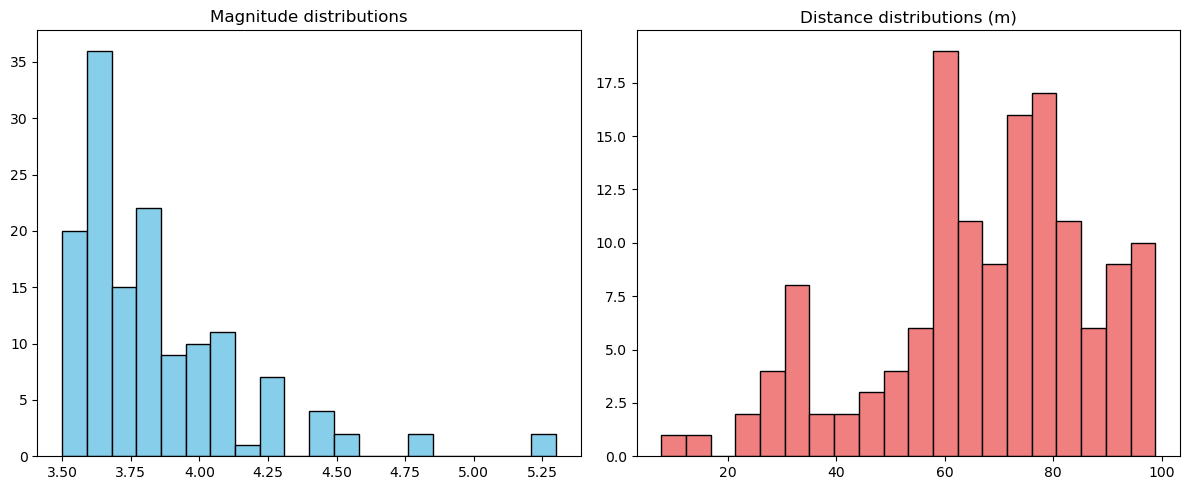

Displaying sample: Event 20210421211742 at Station SOMA


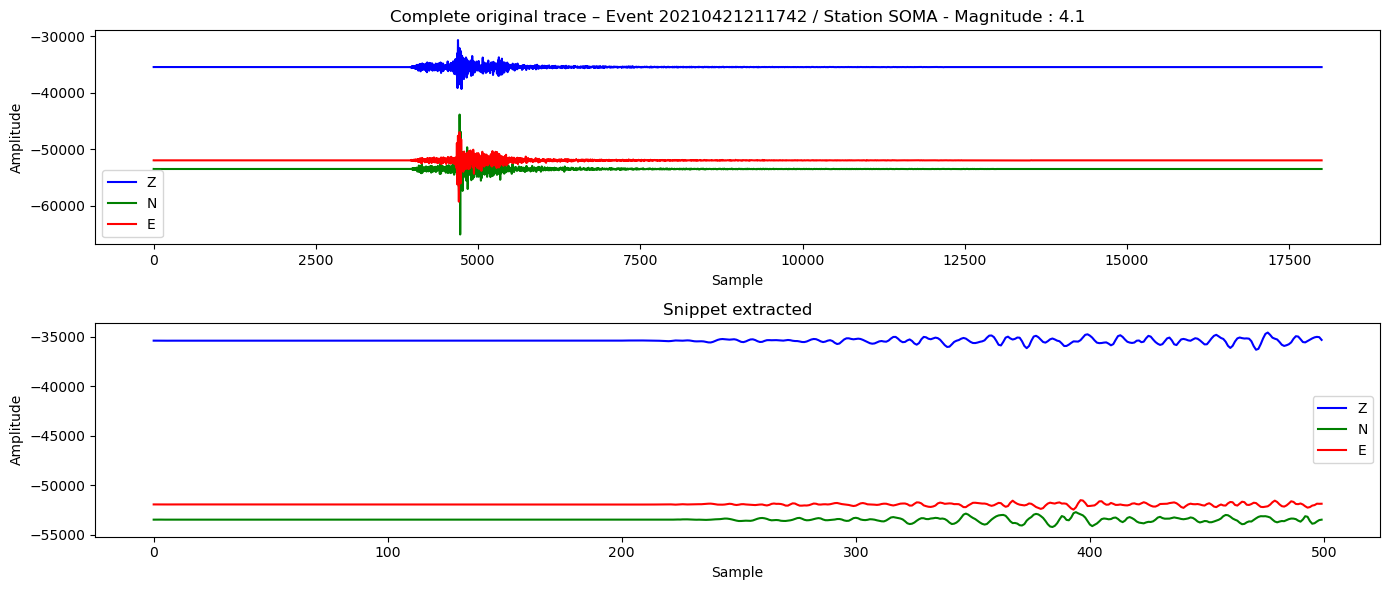

Displaying sample: Event 20210417060830 at Station FOCM


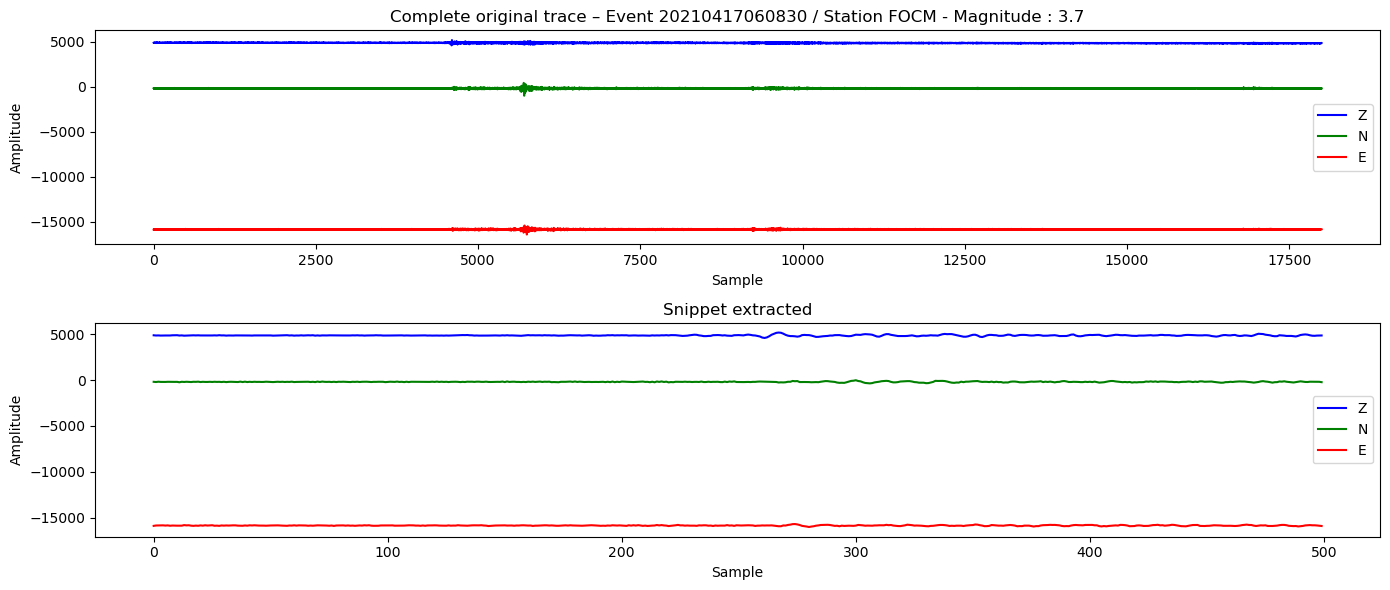

Displaying sample: Event 20210407084721 at Station MLAZ


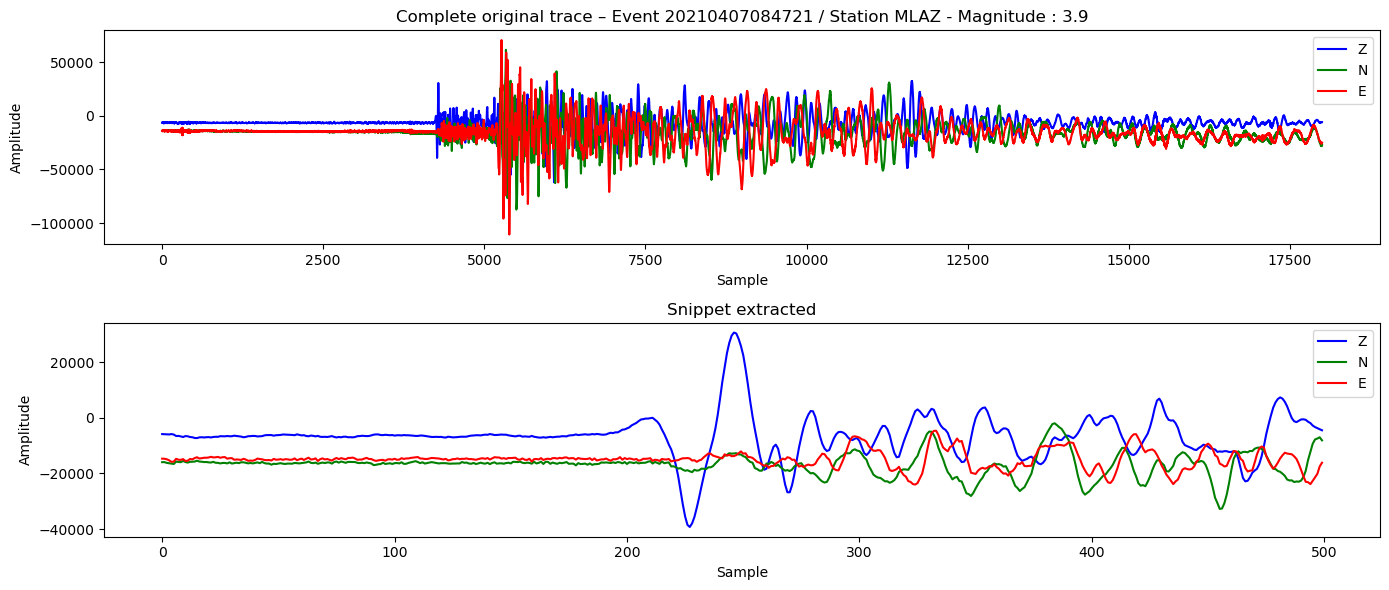

In [28]:
# Note: Requires numpy <= 1.26.4 for compatibility with ObsPy
dataset = build_station_snippet_dataset(seismic_data, one_file ,seconds=5)
check_snippet_shapes(dataset)
check_nan_inf(dataset)
plot_metadata_distribution(dataset)
plot_random_snippet_with_original(dataset, seismic_data)
plot_random_snippet_with_original(dataset, seismic_data)
plot_random_snippet_with_original(dataset, seismic_data)

🚀 Building dataset with 5s snippets at 100 Hz...

📊 Full Statistics for Seismic File Processing

📁 Files detected in folder                      : 5106
❌ Ignored: File not found in catalog            : 26
❌ Ignored: Failed to read trace file            : 0
📄 Events listed in catalog                      : 288043
────────────────────────────────────────────────────────────
🔍 Total traces                                  : 60660
❌ Ignored: Station not in station list          : 5721
❌ Ignored: Sampling rate < 100 Hz             : 15313
❌ Ignored: Missing Z/N/E components             : 29
❌ Ignored: No matching found for these traces   : 0
❌ Ignored: Error during trimming/resampling     : 0
❌ Ignored: Invalid snippet shape/count          : 0
────────────────────────────────────────────────────────────
✅ Valid traces extracted                      : 38013
Valid snippets extracted                       : 12671.0

✅ Every snippets have the same size : (3, 500)
✅ No NaN/Inf values found in 12

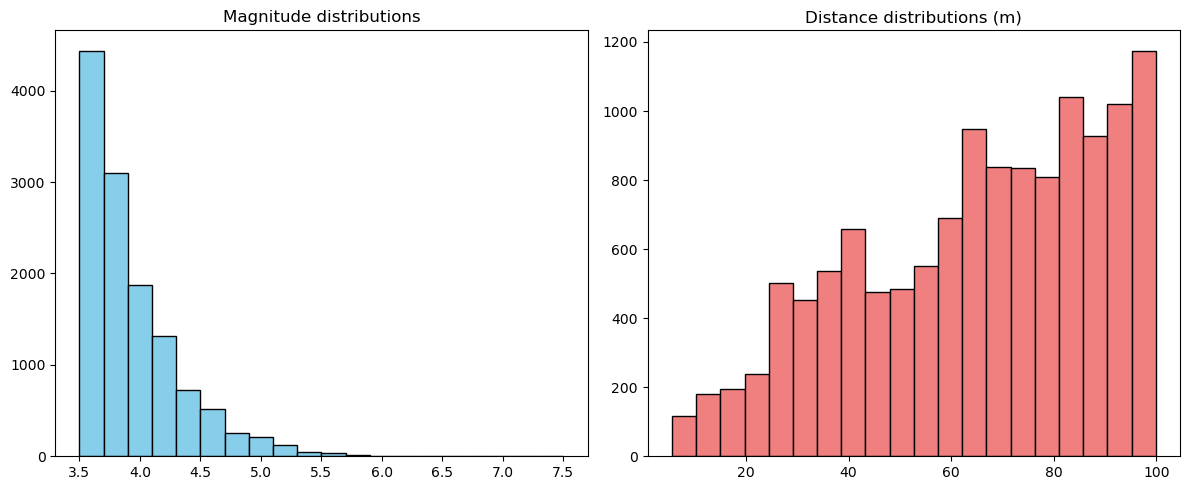

Displaying sample: Event 20180325150158 at Station PHSR


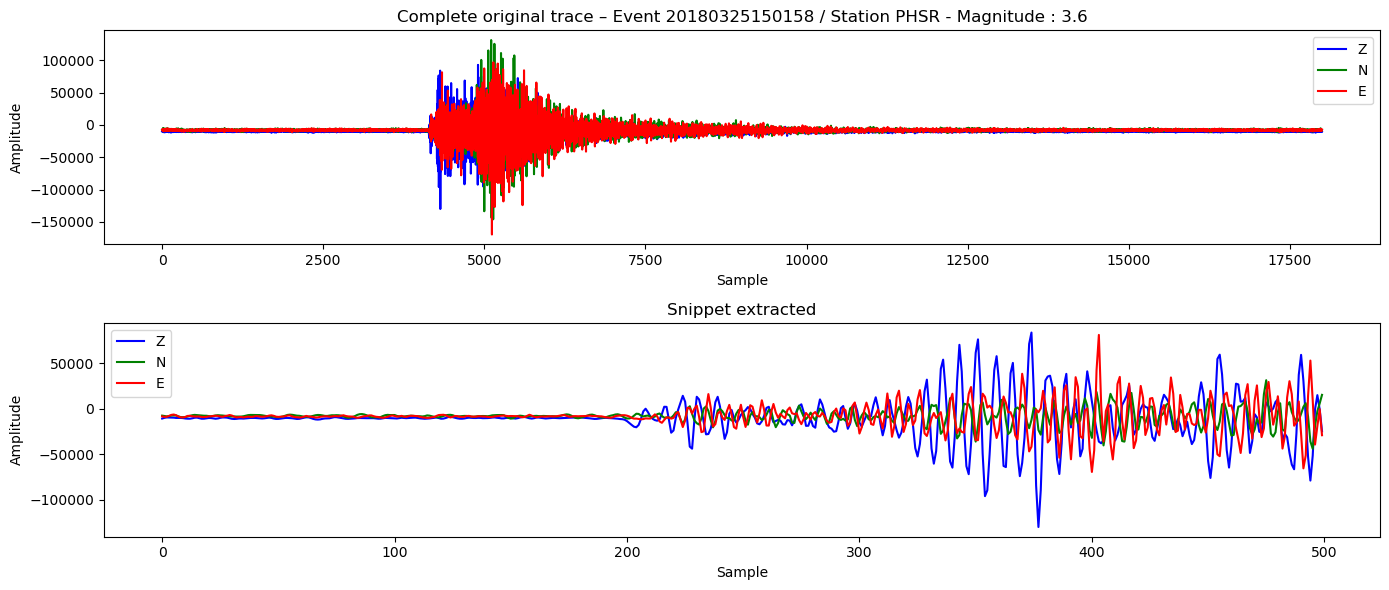

Displaying sample: Event 20230423034006 at Station BODA


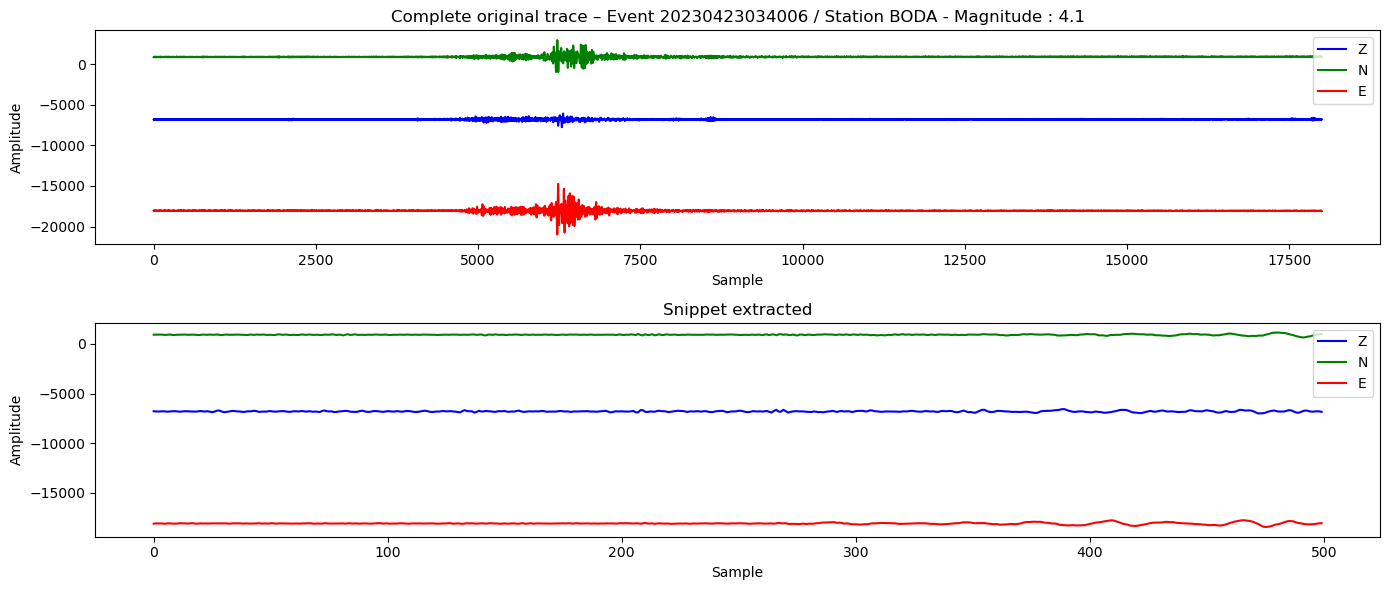

Displaying sample: Event 20160322142310 at Station AKDN


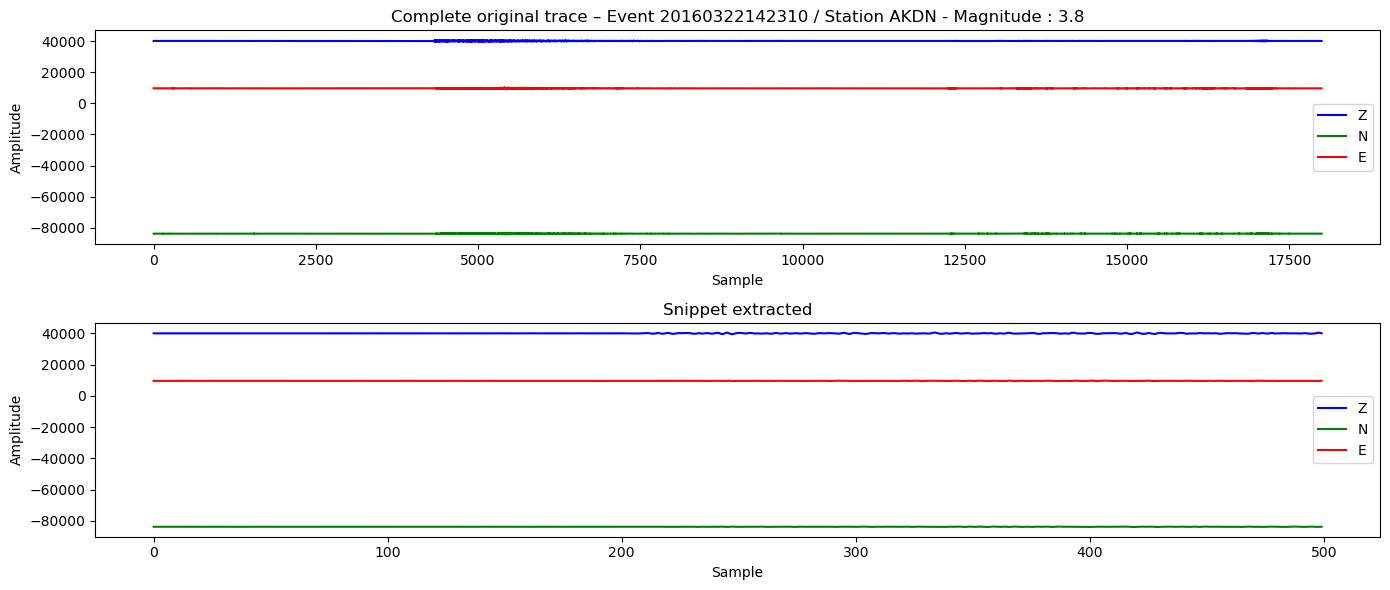

In [29]:
# Configuration parameters for seismic snippet extraction
seconds = 5        # Duration of snippet after P-wave arrival (seconds)
sample_rate = 100  # Target sampling rate for standardization (Hz)# Build complete dataset from all catalog files

# This processes every .mseed file found in the seismic_data folder
# and extracts 3-component waveform snippets around P-wave arrivals
print(f"🚀 Building dataset with {seconds}s snippets at {sample_rate} Hz...")
dataset = build_station_snippet_dataset(
    seismic_data,     # Path to folder containing .mseed files
    all_files,        # Dictionary of all parsed catalog events
    seconds=seconds,
    sample_rate=sample_rate
)
# 1. Verify tensor consistency - critical for ML training
# Ensures all snippets have identical shape [3, n_samples]
check_snippet_shapes(dataset)

# 2. Data integrity check - detect corrupted samples
# Identifies NaN/Inf values that would break neural network training
check_nan_inf(dataset)

# 3. Statistical analysis of dataset distribution
# Visualizes magnitude and distance distributions to assess data balance
# Helps identify potential biases in the training data
plot_metadata_distribution(dataset)

# 4. Visual quality control - manual inspection of random samples
# Compare extracted snippets with original traces to validate:
# - Correct temporal alignment around P-wave arrivals
# - Proper component extraction (Z/N/E)
# - No obvious artifacts from resampling/trimming
plot_random_snippet_with_original(dataset, seismic_data)
plot_random_snippet_with_original(dataset, seismic_data)
plot_random_snippet_with_original(dataset, seismic_data)

# Save processed dataset with descriptive filename including parameters
# This allows easy identification of dataset configuration and prevents
# accidental overwriting of different parameter combinations
df = pd.DataFrame(dataset)
df.to_pickle("seismic_data_"+ str(seconds) + "_seconds_sampling_rate_" + str(sample_rate)  +".pkl")